In [1]:
%%capture
"""Install notebook extensions"""
!pip install nb_black
!pip install line-profiler

"""Load notebook extensions"""
%load_ext nb_black
%load_ext line_profiler

"""Built-ins"""
import gzip
import json
from glob import glob
from typing import Dict

"""Installables"""
import pandas as pd
import requests
import matplotlib.pyplot as plt

"""Plot configuration"""

from cycler import cycler

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (19, 9)
plt.rcParams["axes.prop_cycle"] = cycler(
    "color",
    [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
    ],
)
;

<IPython.core.display.Javascript object>

In [2]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

<IPython.core.display.Javascript object>

In [3]:
def __parse_line(line: str) -> Dict[int, float]:
    def split(line: str):
        for col in line.split("\t"):
            yield col.split(",")

    dic = {}
    name = ""
    for i, tokens in enumerate(split(line)):
        if i == 0:
            name = tokens[0]
            dic = {"date": [], name: []}
        elif len(tokens) > 1:
            dic["date"].append(tokens[0])
            dic[name].append(int(tokens[1]))
    return dic


def totals(*langs: str) -> pd.DataFrame:
    df = None
    for lang in langs:
        with open(f"/home/peter/src/py/Ngrams/res/google/totalcounts-{lang}") as f:
            dic = {}
            name = ""
            for line in f:
                dic.update(__parse_line(line))
            if df is None:
                df = pd.DataFrame(dic).set_index("date")
            else:
                df = df.join(pd.DataFrame(dic).set_index("date"))
        df = df.rename(columns={" ": lang})
    df = df[df.index >= LIMIT]
    df.index = pd.to_datetime(df.index)
    return df


def counts(lang: str):
    for filename in glob(f"/home/peter/src/py/Ngrams/res/google/{lang}/*.gz"):
        with gzip.open(filename, mode="rt") as f:
            for line in f:
                yield __parse_line(line)


def count_word(lang: str, word: str) -> pd.DataFrame:
    for filename in glob(f"/home/peter/src/py/Ngrams/res/google/{lang}/*.gz"):
        with gzip.open(filename, mode="rt") as f:
            for line in f:
                if line.startswith(word + "\t"):
                    df = pd.DataFrame(__parse_line(line)).set_index("date")
                    df = df[df.index >= 1800]
                    df.index = pd.to_datetime(df.index)
                    return df
                elif line[: line.find("\t")] > word:
                    print(line[: line.find("\t")])


def count_words(lang: str, *words: str) -> pd.DataFrame:
    dfs = []
    done = []
    for filename in glob(f"/home/peter/src/py/Ngrams/res/google/{lang}/*.gz"):
        with gzip.open(filename, mode="rt") as f:
            for line in f:
                if len(done) == len(words):
                    break
                for word in words:
                    if line.startswith(word + "\t"):
                        dfs.append(pd.DataFrame(__parse_line(line)).set_index("date"))
                        done.append(word)
                words = [w for w in words if w not in done]
                if not words:
                    break
        words = [w for w in words if w not in done]
        if not words:
            break
    result = dfs[0]
    result = result[result.index >= LIMIT]
    for df in dfs:
        result = result.join(df)
    return result


def frequency(lang: str, word: str) -> pd.DataFrame:
    return count_word(lang, word).divide(totals(lang))


LANG2CORPUS = {"de": 31, "en": 26, "fr": 30}
LIMIT = "1800"


def web_query(lang: str, *words: str) -> pd.DataFrame:
    url = f"https://books.google.com/ngrams/json?content={'%2C'.join([w.replace(' ', '+') for w in words])}&year_start={LIMIT}&year_end=2019&corpus={LANG2CORPUS[lang]}&smoothing=0"
    response = json.loads(requests_retry_session().get(url).text)
    df = pd.DataFrame(
        {r["ngram"]: r["timeseries"] for r in response},
        index=[str(x + int(LIMIT)) for x in range(len(response[0]["timeseries"]))],
    )
    df.index = pd.to_datetime(df.index)
    return df


NPERQUERY = 10


def frequencies(lang: str, *words: str, **kwargs):
    if "local" in kwargs and kwargs["local"]:
        return count_words(lang, *words).divide(totals(lang))
    i = 0
    dfs = [
        web_query(lang, *(words[i : i + NPERQUERY]))
        for i in range(0, len(words), NPERQUERY)
    ]
    df = dfs[0]
    for d in dfs[1:]:
        df = df.join(d)
    df.index = pd.to_datetime(df.index)
    return df

<IPython.core.display.Javascript object>

In [4]:
def keywords(lang: str):
    df = pd.read_csv(
        f"/home/peter/src/py/Ngrams/res/{lang}.tsv",
        sep="\t",
        header=None,
        index_col=1,
    )
    return df.groupby(df.index)[0].apply(list)


def systems(lang: str):
    words = keywords(lang)
    dfs = [
        pd.DataFrame(frequencies(lang, *words[system]).sum(axis=1), columns=[system])
        for system in words.index
    ]
    result = dfs[0]
    for df in dfs[1:]:
        result = result.join(df)
    return result


LONG = {"de": "German", "en": "English", "fr": "French"}


def plot_systems(lang: str):
    return (
        systems(lang)
        # .rolling("90D", min_periods=2)
        # .mean()
        .plot(
            title=f"Frequency in {LONG[lang]} books, source: doi:10.1126/science.1199644",
            ylabel="frequency [%]",
            legend=True,
        )
    )

<IPython.core.display.Javascript object>

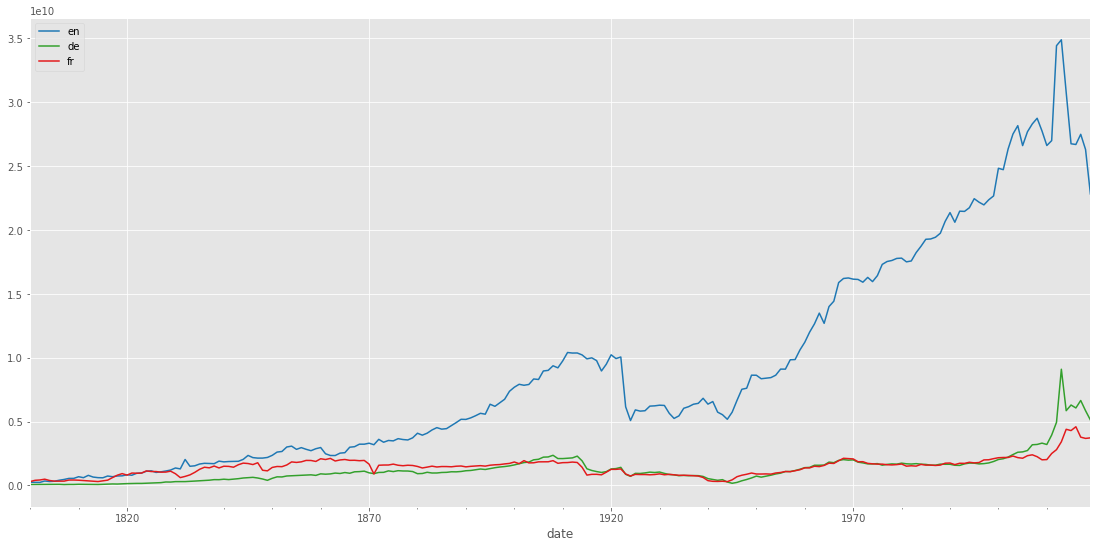

<IPython.core.display.Javascript object>

In [5]:
totals("en", "de", "fr").plot()
plt.show()

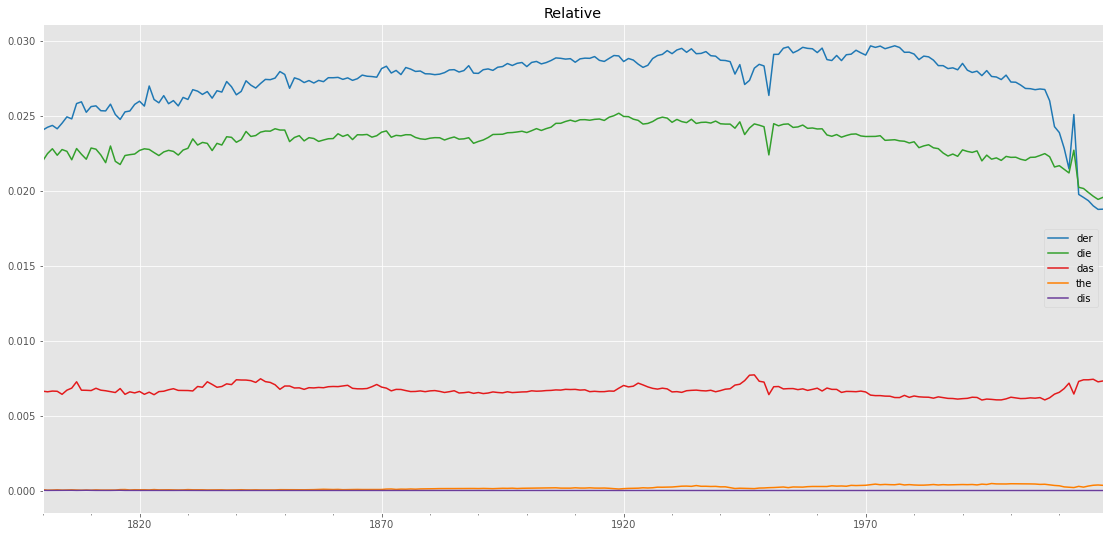

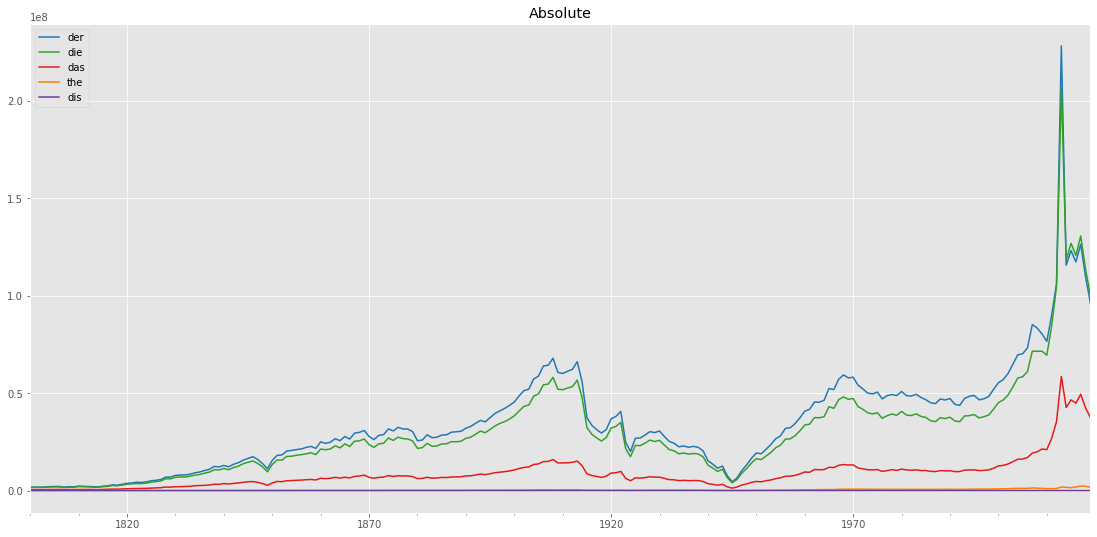

<IPython.core.display.Javascript object>

In [6]:
df = frequencies("de", "der", "die", "das", "the", "dis")
df.plot(title="Relative")
df.mul(totals("de")["de"], axis=0).plot(title="Absolute")
plt.show()

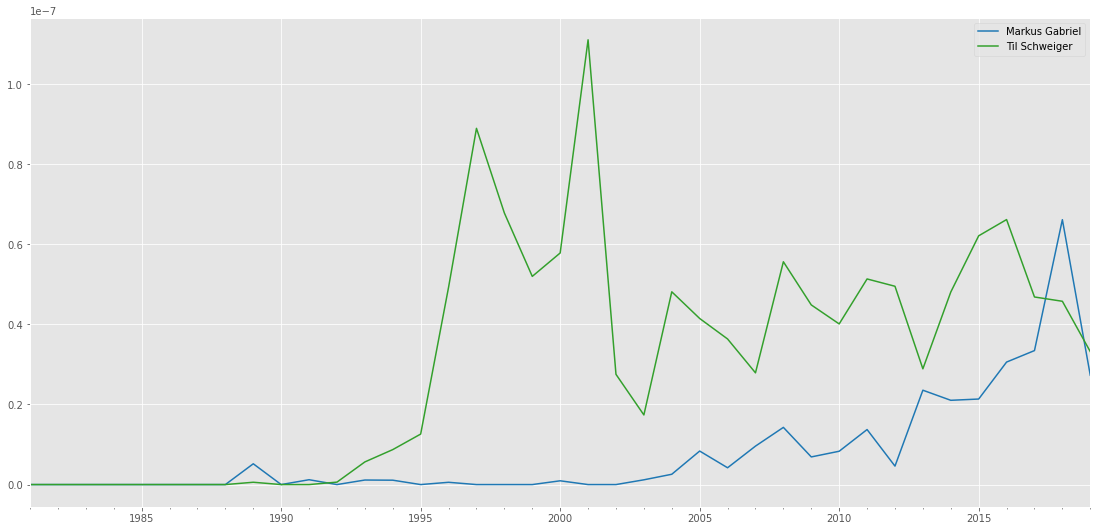

<IPython.core.display.Javascript object>

In [7]:
df = frequencies("de", "Markus Gabriel", "Til Schweiger")
df[df.index > "1980"].plot()
plt.show()

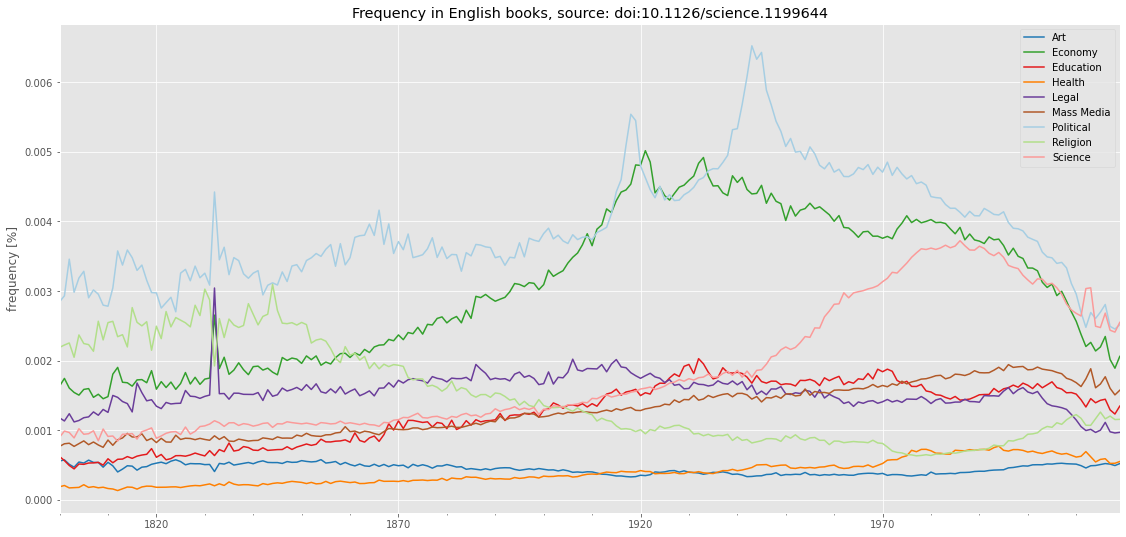

<IPython.core.display.Javascript object>

In [8]:
plot_systems("en")
plt.show()

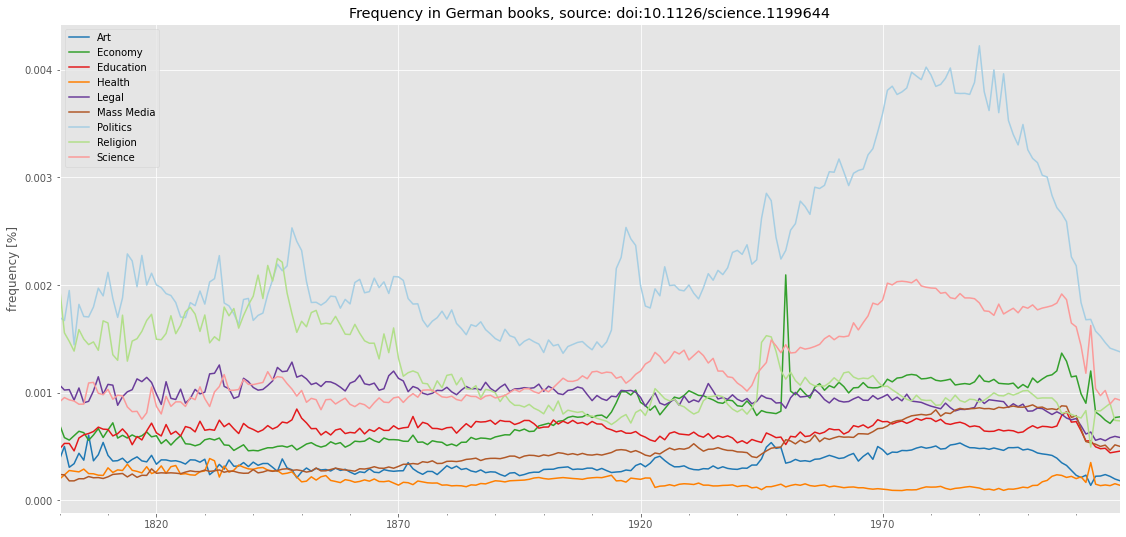

<IPython.core.display.Javascript object>

In [10]:
plot_systems("de")
plt.show()

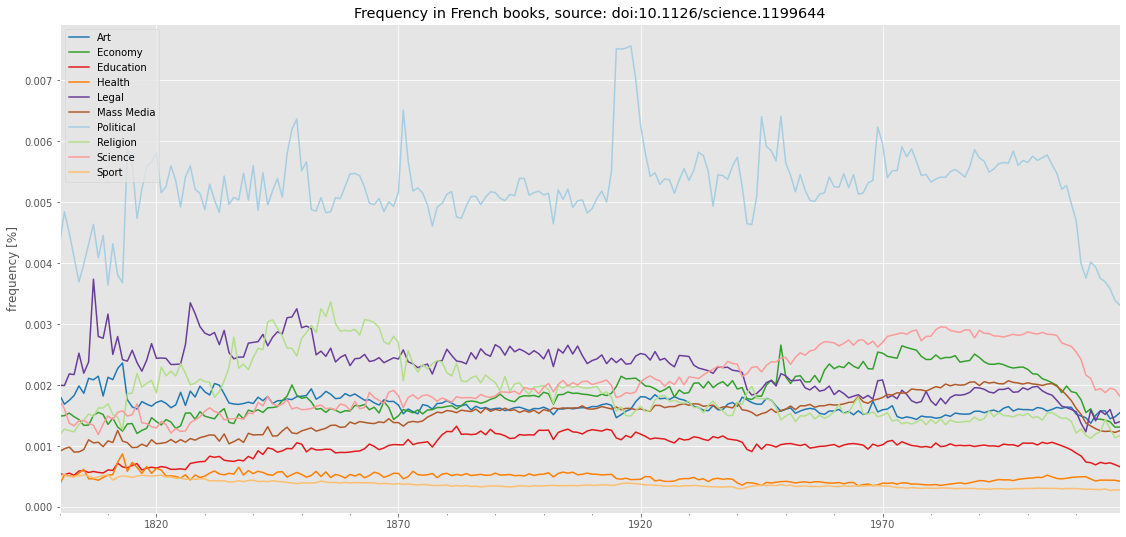

<IPython.core.display.Javascript object>

In [11]:
plot_systems("fr")
plt.show()